In [1]:
import transformers

from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

import torch

import torch.nn.functional as F

import numpy as np

import pandas as pd

import seaborn as sns

from pylab import rcParams

import matplotlib.pyplot as plt

from matplotlib import rc

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report

from collections import defaultdict

from textwrap import wrap

from torch import nn, optim

from torch.utils.data import Dataset, DataLoader





In [2]:
df = pd.read_csv("./dataset/original_data.csv")

df.head()

,lyrics,sentiment
0,aint ever trapped bando oh lord dont get wrong...,positive
1,drink go smoke go feel got let go care get los...,positive
2,dont live planet earth found love venus thats ...,negative
3,trippin grigio mobbin light low trippin grigio...,neutral
4,see midnight panther gallant brave found found...,negative


In [3]:
df.shape

(158353, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158353 entries, 0 to 158352
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   lyrics     158072 non-null  object
 1   sentiment  158353 non-null  object
dtypes: object(2)
memory usage: 2.4+ MB


In [5]:
category_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df['sentiment'] = df['sentiment'].replace(category_mapping)

In [6]:
df

,lyrics,sentiment
0,aint ever trapped bando oh lord dont get wrong...,2
1,drink go smoke go feel got let go care get los...,2
2,dont live planet earth found love venus thats ...,0
3,trippin grigio mobbin light low trippin grigio...,1
4,see midnight panther gallant brave found found...,0
...,...,...
158348,live borrowed time headshot pretty good ive sc...,2
158349,frozin time forever carrying torch long hear h...,1
158350,hard girl nice boy room night pretty site here...,2
158351,want chose die buried rubix cube sleep inside ...,0


In [7]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [8]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [9]:
# Exemplo de código adaptado para o seu dataset
sample_idx = 0  # Índice de exemplo a ser utilizado

sample_lyrics = df['lyrics'].iloc[sample_idx]  # Texto da letra de música
sample_sentiment = df['sentiment'].iloc[sample_idx]  # Sentimento correspondente

# Codificar o texto e o sentimento usando o tokenizer
encoding = tokenizer.encode_plus(
    sample_lyrics,
    max_length=32,
    add_special_tokens=True,  # Adicionar '[CLS]' e '[SEP]'
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt'  # Retornar tensores PyTorch
)

encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/pereira/anaconda3/envs/daa/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'attention_mask'])

In [10]:
print(len(encoding['input_ids'][0]))

encoding['input_ids'][0]

32


tensor([  101,  9562,  1204,  1518,  7333,  1467,  1186,  9294,  7692,  1274,
         1204,  1243,  2488,  1221,  2337, 11437,  9705,  1161, 13280,  1282,
        10565,  1221,  1271,  1474, 13224,  2824,  7533,  1267,  1948,  1299,
         1838,   102])

In [11]:
print(len(encoding['attention_mask'][0]))

encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]])

In [12]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'ain',
 '##t',
 'ever',
 'trapped',
 'band',
 '##o',
 'oh',
 'lord',
 'don',
 '##t',
 'get',
 'wrong',
 'know',
 'couple',
 'ni',
 '##gg',
 '##a',
 'im',
 'place',
 'everybody',
 'know',
 'name',
 'say',
 'gotta',
 'watch',
 'attitude',
 'see',
 'money',
 'man',
 'start',
 '[SEP]']

In [13]:
token_lens = []

df = df.dropna(subset=['lyrics'])  # Remover linhas com valores nulos na coluna 'lyrics'

for txt in df['lyrics']:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))


<ipython-input-14-fee7fabda88f>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


Text(0.5, 0, 'Token count')

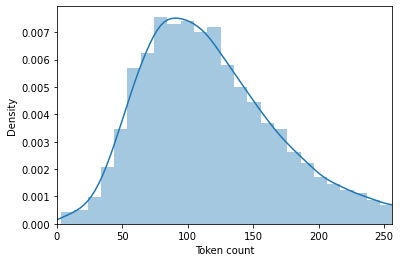

In [14]:
sns.distplot(token_lens)

plt.xlim([0, 256])

plt.xlabel('Token count')

In [15]:
MAX_LEN = 200

In [16]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):

    self.reviews = reviews

    self.targets = targets

    self.tokenizer = tokenizer

    self.max_len = max_len

  def __len__(self):

    return len(self.reviews)

  def __getitem__(self, item):

    review = str(self.reviews[item])

    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(

      review,

      add_special_tokens=True,

      max_length=self.max_len,

      return_token_type_ids=False,

      pad_to_max_length=True,

      return_attention_mask=True,

      return_tensors='pt',

    )

    return {

      'review_text': review,

      'input_ids': encoding['input_ids'].flatten(),

      'attention_mask': encoding['attention_mask'].flatten(),

      'targets': torch.tensor(target, dtype=torch.long)

    }

In [17]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)

df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=42)

In [18]:
df_train_sampled = df_train.sample(n=40000, random_state=42)
df_train = df_train_sampled

In [19]:
df_train.shape, df_val.shape, df_test.shape

((40000, 2), (7904, 2), (7904, 2))

In [20]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.lyrics.to_numpy(),

    targets=df.sentiment.to_numpy(),

    tokenizer=tokenizer,

    max_len=max_len)

  return DataLoader(ds, batch_size=batch_size, num_workers=4)

In [21]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)

val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [22]:
data = next(iter(train_data_loader))

data.keys()

/home/pereira/anaconda3/envs/daa/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/pereira/anaconda3/envs/daa/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_l

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [23]:
print(data['input_ids'].shape)

print(data['attention_mask'].shape)

print(data['targets'].shape)

torch.Size([16, 200])
torch.Size([16, 200])
torch.Size([16])


#  BERT and HuggingFace

In [24]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask'],
  return_dict = False   # this is needed to get a tensor as result
)

In [26]:
last_hidden_state.shape


torch.Size([1, 32, 768])

In [27]:
bert_model.config.hidden_size

768

In [28]:
pooled_output.shape

torch.Size([1, 768])

In [29]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):

    super(SentimentClassifier, self).__init__()

    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

    self.drop = nn.Dropout(p=0.3)

    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):

    _, pooled_output = self.bert(

      input_ids=input_ids,

      attention_mask=attention_mask

    )

    output = self.drop(pooled_output)

    return self.out(output)

In [30]:
class_names = ['negative', 'neutral', 'positive']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [31]:
model = SentimentClassifier(len(class_names))

model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
input_ids = data['input_ids'].to(device)

attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length

print(attention_mask.shape) # batch size x seq length

torch.Size([16, 200])
torch.Size([16, 200])


In [33]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.1955, 0.1314, 0.6731],
        [0.4776, 0.3091, 0.2134],
        [0.2305, 0.3654, 0.4041],
        [0.2995, 0.2282, 0.4723],
        [0.2955, 0.2925, 0.4120],
        [0.2784, 0.2988, 0.4228],
        [0.3290, 0.2747, 0.3964],
        [0.3950, 0.2454, 0.3595],
        [0.1996, 0.3719, 0.4285],
        [0.2191, 0.3974, 0.3836],
        [0.3433, 0.3336, 0.3231],
        [0.1780, 0.3258, 0.4963],
        [0.3094, 0.3743, 0.3163],
        [0.2863, 0.3936, 0.3201],
        [0.3760, 0.3931, 0.2310],
        [0.2971, 0.4607, 0.2422]], grad_fn=<SoftmaxBackward0>)

In [34]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

/home/pereira/anaconda3/envs/daa/lib/python3.9/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [35]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        inputs_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        loss
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [36]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [37]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------


/home/pereira/anaconda3/envs/daa/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/pereira/anaconda3/envs/daa/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_l

Train loss 1.1191165843725204 accuracy 0.355475


/home/pereira/anaconda3/envs/daa/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/pereira/anaconda3/envs/daa/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_l

Val   loss 1.1048741063125702 accuracy 0.35108805668016196

Epoch 2/10
----------


/home/pereira/anaconda3/envs/daa/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/pereira/anaconda3/envs/daa/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_l

: 

: 